## Gradient Boosting##

**Gradient Boosting** is an ensemble method which combines a set of weak predictors to produce a strong predictor. Its a forward stage-wise process at each stage we add predictors which would reduce the loss function most by looking at the local gradient of the loss function. 


For a given dataset with $n$ examples and $m$ features, a tree ensemble model uses $K$ additive functions to predict the output 
$\hat{y}_i = \sum_{k=1}^{K}f_k(x_i)$

Algorithm of **Gradient Boosting** is as follows:
1. Initialize $f_0(x) = \text{arg min}_{\gamma} \sum_{i=1}^{n} \mathcal{L}(y_i, \gamma)$
2. For m=1 to K:
    1. For i = 1,2,....n compute $r_{im} = - \left [ \frac{\partial \mathcal{L}(y_i, f(x_i))}{\partial f(x_i)} \right ]$
    2. Fit a regression tree to the target $r_{im}$ giving terminal regions $R_{jm},j=1,2,..J_m$.
    3. For $j =1,2,...,J_m$ compute
        $\gamma_{jm} = \text{arg min}_{\gamma} \sum_{x_i \in R_{jm}} \mathcal{L}(y_i, f_{m-1}(x_i)+\gamma)$
    4. Update $f_m(x) = f_{m-1}(x) + \sum_{j=1}^{J_m}\gamma_{jm}\mathcal{I}(x \in R_{jm})$.
    
3. Compute output $\hat{f}(x) = f_M(x)$.

Above is general **Gradient Boosting** there are various flavors of **Gradient Boosting**, **xgBoost**, **LightGBM**, and **CatBoost** all these libraries apply slightly different loss functions and have various optimizations. In the notebook below we will use SkLearn to do gradient boosting.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#Make the sheet width 100%
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}</style>" ))

#### Load Avila dataset
https://archive.ics.uci.edu/ml/datasets/Avila

In [2]:
#Load dataset
df_avila_train=pd.read_csv("../data/avila/avila-tr.txt",header=None)
df_avila_test=pd.read_csv("../data/avila/avila-ts.txt",header=None) 

In [3]:
df_avila_train.head()

,0,1,2,3,4,5,6,7,8,9,10
0,0.266074,-0.165620,0.320980,0.483299,0.172340,0.273364,0.371178,0.929823,0.251173,0.159345,A
1,0.130292,0.870736,-3.210528,0.062493,0.261718,1.436060,1.465940,0.636203,0.282354,0.515587,A
2,-0.116585,0.069915,0.068476,-0.783147,0.261718,0.439463,-0.081827,-0.888236,-0.123005,0.582939,A
3,0.031541,0.297600,-3.210528,-0.583590,-0.721442,-0.307984,0.710932,1.051693,0.594169,-0.533994,A
4,0.229043,0.807926,-0.052442,0.082634,0.261718,0.148790,0.635431,0.051062,0.032902,-0.086652,F


In [4]:
#Make X_train, X_test, y_train, y_test
X_train = df_avila_train[range(0,10)].values
y_train = df_avila_train[10].values
X_test = df_avila_test[range(0,10)].values
y_test = df_avila_test[10].values

assert y_test.shape[0] == X_test.shape[0]
assert y_train.shape[0] == X_train.shape[0]

print(f"Size of test set = {y_test.shape[0]}")
print(f"Size of train set = {y_train.shape[0]}")

Size of test set = 10437
Size of train set = 10430


In [5]:
#Apply LabelEncoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)
print(f"y_train {np.bincount(y_train)}")
print(f"y_test {np.bincount(y_test)}")

y_train [4286    5  103  352 1095 1961  446  519  831   44  522  266]
y_test [4286    5  103  353 1095 1962  447  520  832   45  522  267]


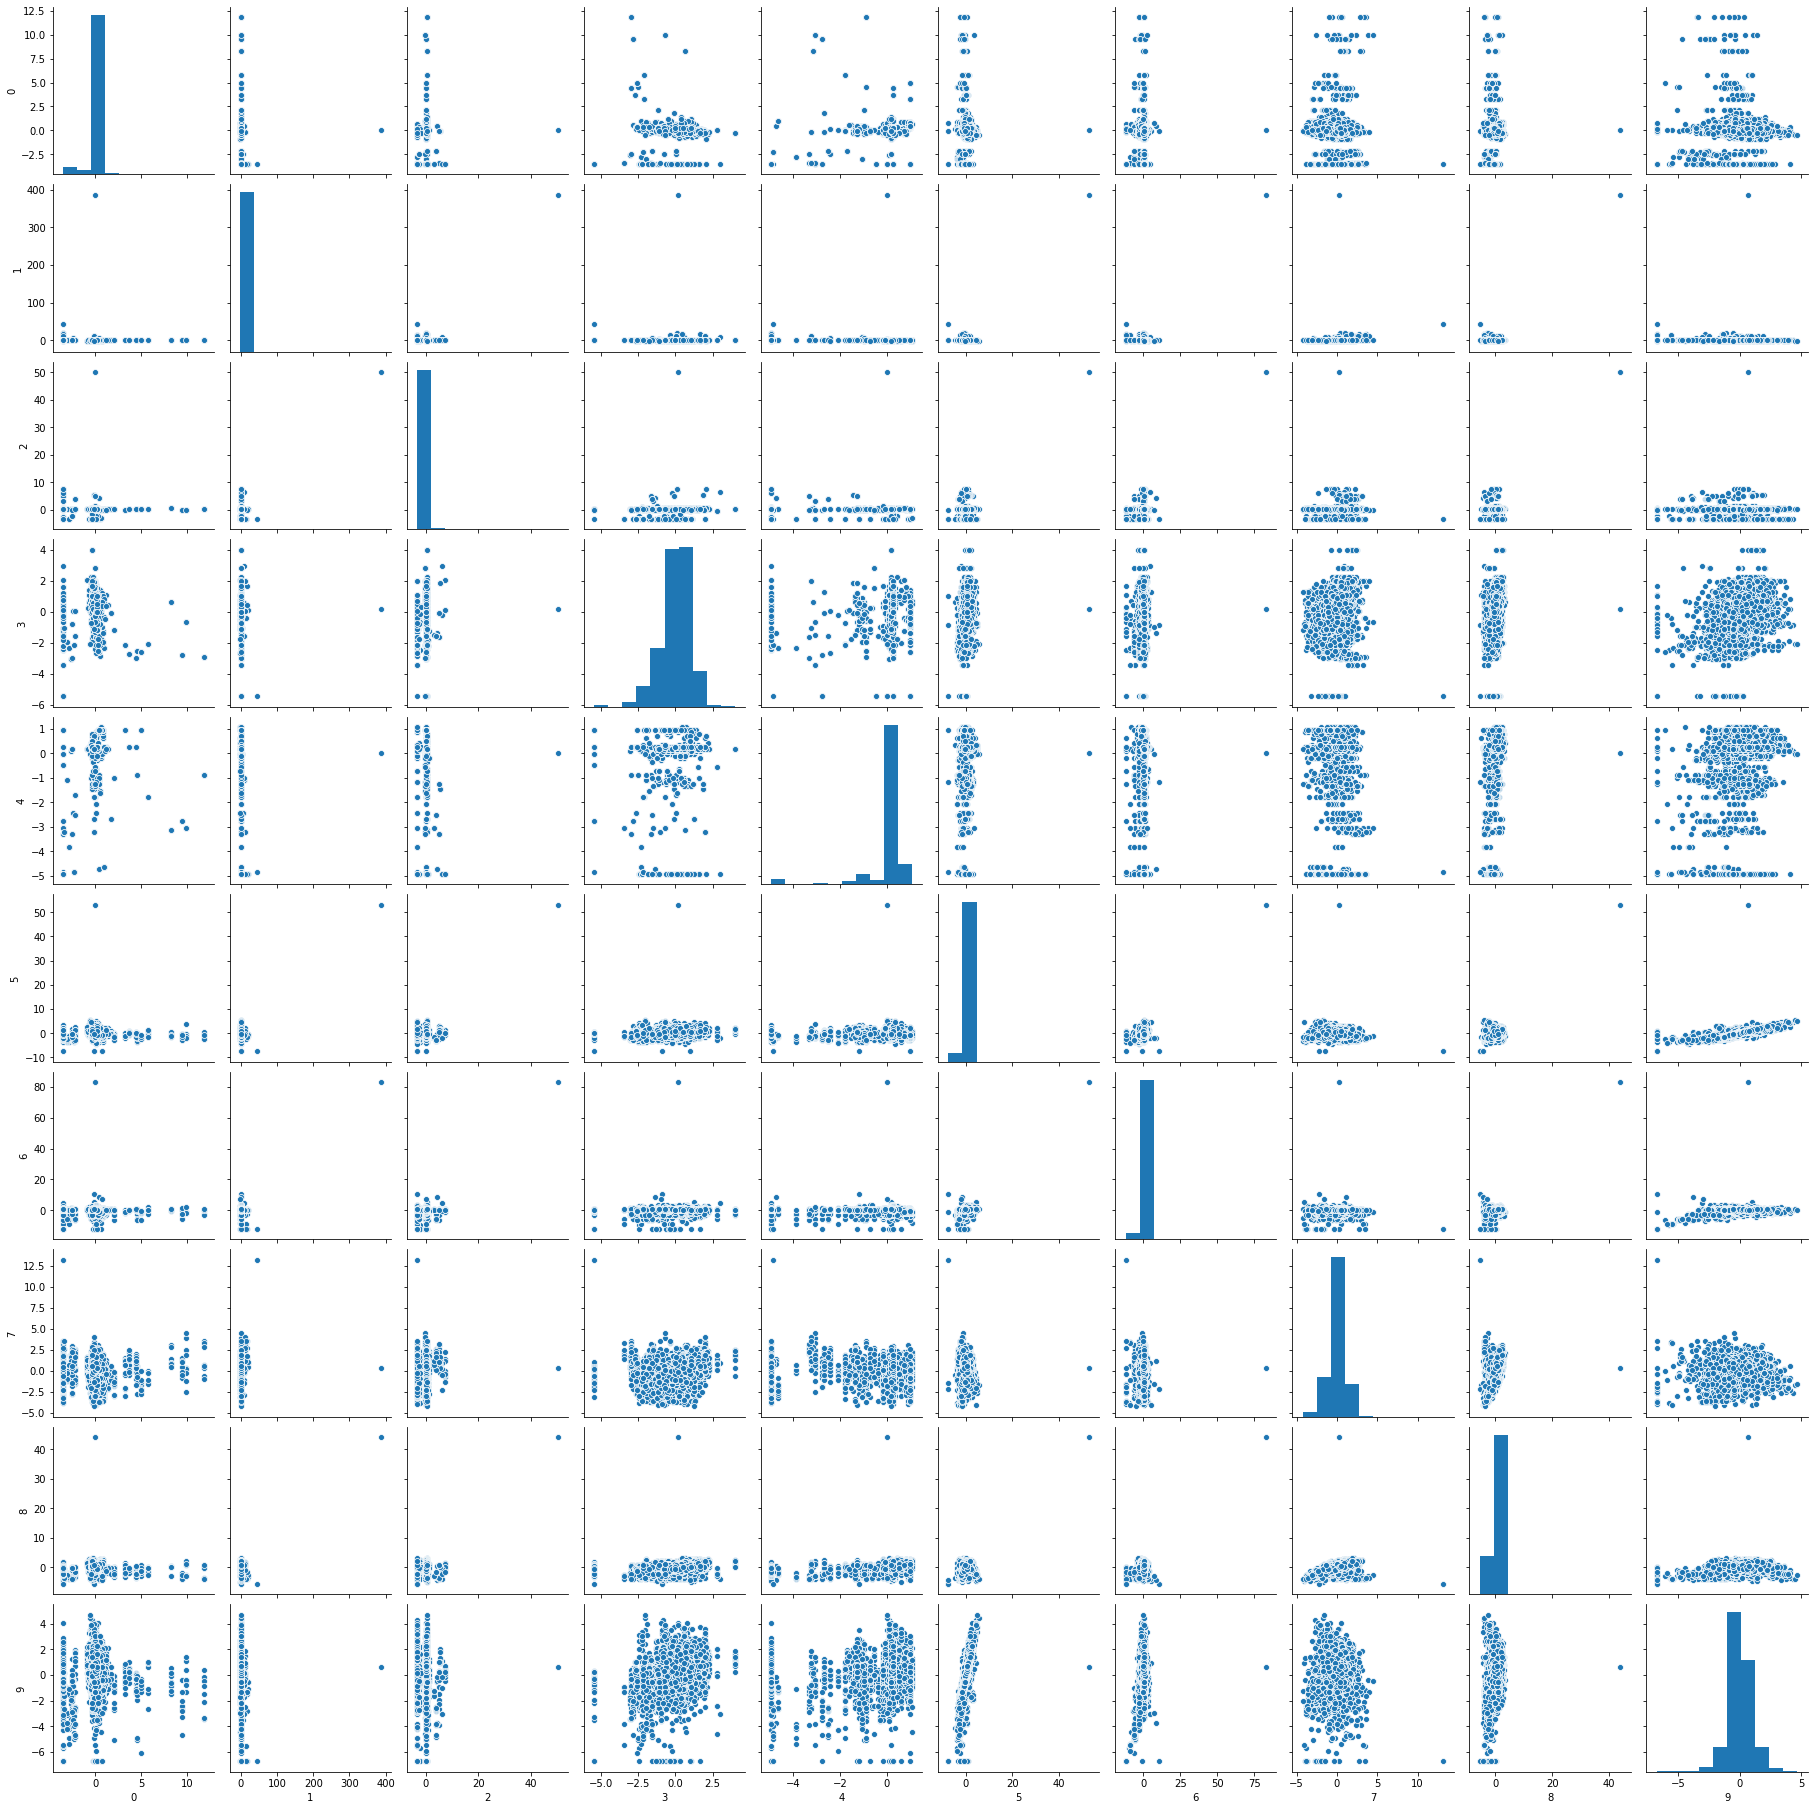

In [6]:
import seaborn as sns
sns.pairplot(df_avila_train)

In [7]:
#Lets first standardize the X
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

In [8]:
#Now lets fit logistic to the data
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, max_iter=500)
clf.fit(X_train_std, y_train)
print(f"Train score={clf.score(X_train_std, y_train):.3}")
print(f"Test score={clf.score(X_test_std, y_test):.3}")

Train score=0.564
Test score=0.562


Logistic regression didn't do very well on this data set

In [9]:
#Now lets apply decision tree model
from sklearn import tree
clf = tree.DecisionTreeClassifier(min_samples_split=2)
clf = clf.fit(X_train_std, y_train)
print(f"Train score={clf.score(X_train_std, y_train):.3}")
print(f"Test score={clf.score(X_test_std, y_test):.3}")

Train score=1.0
Test score=0.97


Decision tree model did okay on the data set but seems to be over fitting

In [10]:
#Now lets fit random forest
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=500, min_samples_split=2)
clf.fit(X_train_std, y_train)
print(f"Train score={clf.score(X_train_std, y_train):.3}")
print(f"Test score={clf.score(X_test_std, y_test):.3}")

Train score=1.0
Test score=0.985


Ramdom forest did very well in the data set

In [11]:
#Lets first apply gradient boosting classifier of SkLearn
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(random_state=0, 
                                n_estimators=1000, 
                                learning_rate=0.1, 
                                validation_fraction=0.1,
                                n_iter_no_change=5)
clf.fit(X_train_std, y_train)
print(f"Train score={clf.score(X_train_std, y_train):.3}")
print(f"Test score={clf.score(X_test_std, y_test):.3}")
print(f"Number of trees after early stopping={clf.n_estimators_}")

Train score=1.0
Test score=0.999
Number of trees after early stopping=555


**Gradient boosting** with early terminal condition nailed it almost perfect test score.

Text(0.5, 0, 'Number of Trees')

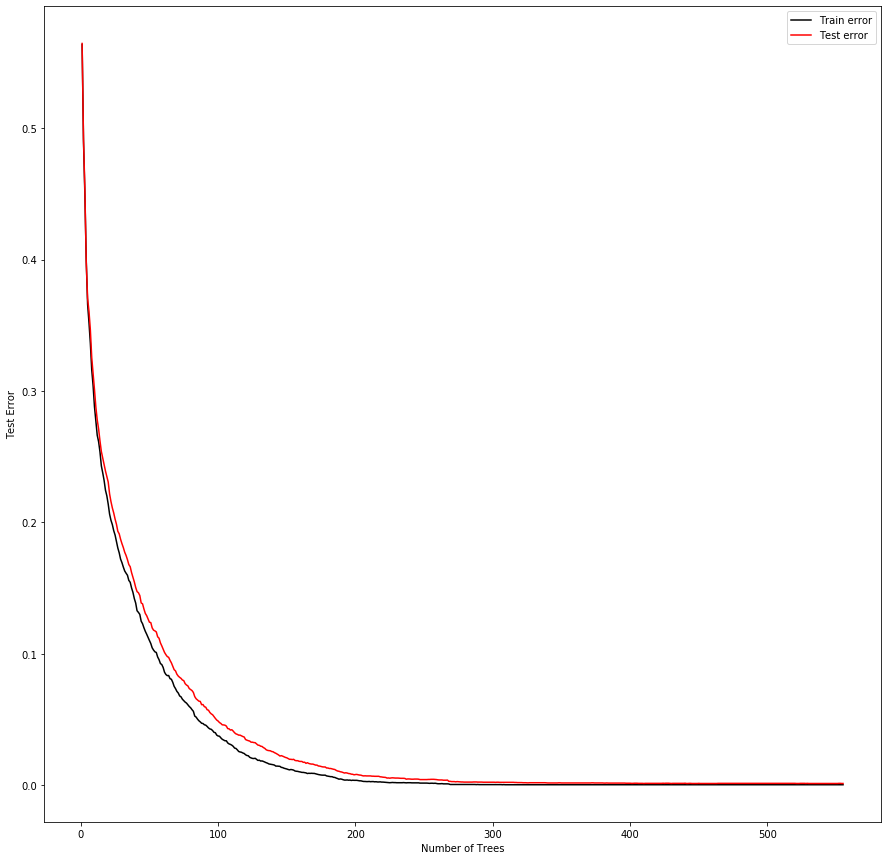

In [12]:
from sklearn.metrics import accuracy_score
test_errors = []
for test_predict in clf.staged_predict(X_test_std):
    test_errors.append(1. - accuracy_score(test_predict, y_test))
    
train_errors = []
for train_predict in clf.staged_predict(X_train_std):
    train_errors.append(1. - accuracy_score(train_predict, y_train))
    
n_trees = len(clf)
plt.figure(figsize=(15, 15))
plt.plot(range(1, n_trees + 1),
         train_errors, c='black', label='Train error')
plt.plot(range(1, n_trees + 1),
        test_errors, c='red', label='Test error')
plt.legend()
plt.ylabel('Test Error')
plt.xlabel('Number of Trees')

Above is a plot of test and train error with number of trees in gradient boosting. We can see around 300 it is reaching a very good performance

Text(0.5, 1.0, 'Feature Importance')

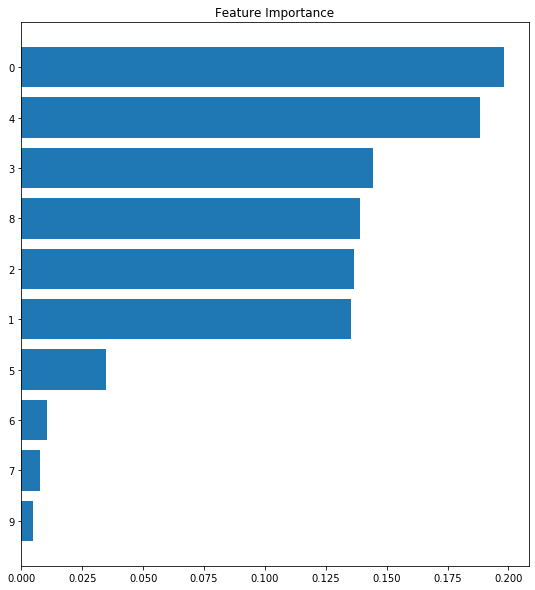

In [13]:
#Below we have plotted feature importance of all the features in this regression.
feature_importance = clf.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(df_avila_train.columns[:-1])[sorted_idx])
plt.title('Feature Importance')